## CNNが学習した内容を可視化する

### 1. CNNの中間層の活性化の可視化
* 目的: CNNの一連の層によって入力がどのように変換されるのかを理解し、CNNの個々のフィルタの意味を把握するため

### 2. CNNのフィルタの可視化
* 目的: CNNの各フィルタが受け入れる視覚パターンや視覚概念がどのようなものであるのかを正確に理解するため

### 3. 画像におけるクラス活性化のヒートマップの可視化
* 目的: 画像のどの部分が特定のクラスに属していると見なされたのかを理解するため。これにより、画像内のオブジェクトを局所化できるようになる。

In [1]:
from keras import models
import matplotlib.pyplot as plt
from tqdm import tqdm 
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import sys
import cv2
import os
input_size = 256
%matplotlib inline

Using TensorFlow backend.


In [2]:
model = models.load_model('models/simplest_cnn_model_mini_1.h5')
# model = models.load_model('models/VGG16_mini_extended_fine2.h5')
# model = models.load_model('models/4_dense_mini.h5')

In [3]:
len(model.layers)

13

### 1. CNNの中間層の活性化の可視化
* 目的: CNNの一連の層によって入力がどのように変換されるのかを理解し、CNNの個々のフィルタの意味を把握するため

In [4]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 128)      

In [5]:
base_dir = "mini_pictures"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
test_dir = os.path.join(base_dir,"test")

Audi_a3_dir = os.path.join(test_dir,"Audi-a3")
fnames = [os.path.join(Audi_a3_dir,fname) for fname in os.listdir(Audi_a3_dir)]

img_path = fnames[3]
print(img_path)

mini_pictures\test\Audi-a3\Audi-a3_5ee6ce7e5db6_11.jpg


(1, 256, 256, 3)


<function matplotlib.pyplot.show(*args, **kw)>

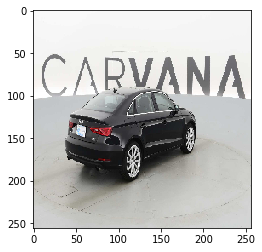

In [6]:
img = image.load_img(img_path, target_size=(input_size,input_size))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show

### 入力テンソルと出力テンソルのリストに基づいてモデルをインスタンス化

In [7]:
# 出力側の8つの層から出力を抽出
out_num = 8
layer_outputs = [layer.output for layer in model.layers[:out_num]]

#　特定の入力をもとに、これらの出力を返すモデルを作成
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

### モデルを予測モードで実行

In [8]:
# 8つのNumpy配列（層の活性化ごとに１つ）のリストを返す
activations = activation_model.predict(img_tensor)
print(len(activations))

8


### 第一層の最後のチャネルを可視化

(1, 254, 254, 32)


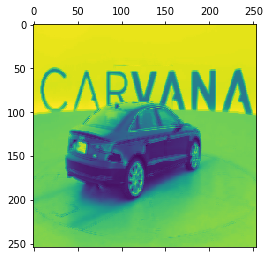

In [9]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0,:,:,-1], cmap="viridis")
plt.show()

この写真よりこのチャネルがエンコードしているのは、対角エッジ検出器と考えられる。

### 第一層の最初のチャネルを可視化

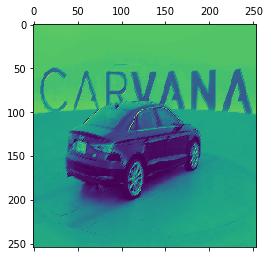

In [10]:
plt.matshow(first_layer_activation[0,:,:,0], cmap='viridis')
plt.show()

上のチャネルはフレームの検出器になっている

### 全ての中間層の活性化マップごとに全てのチャネルを抽出してプロットする。

n_features : 32 (1, 254, 254, 32)
n_features : 32 (1, 127, 127, 32)
n_features : 64 (1, 125, 125, 64)


C:\Users\ibuki\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


n_features : 64 (1, 62, 62, 64)
n_features : 128 (1, 60, 60, 128)
n_features : 128 (1, 30, 30, 128)
n_features : 128 (1, 28, 28, 128)
n_features : 128 (1, 14, 14, 128)


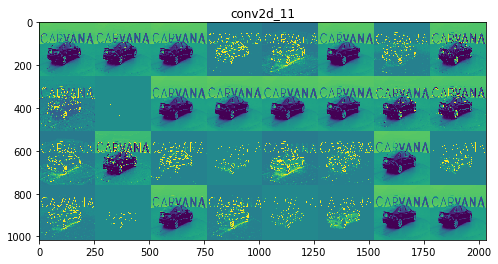

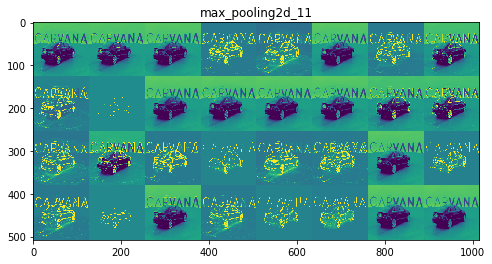

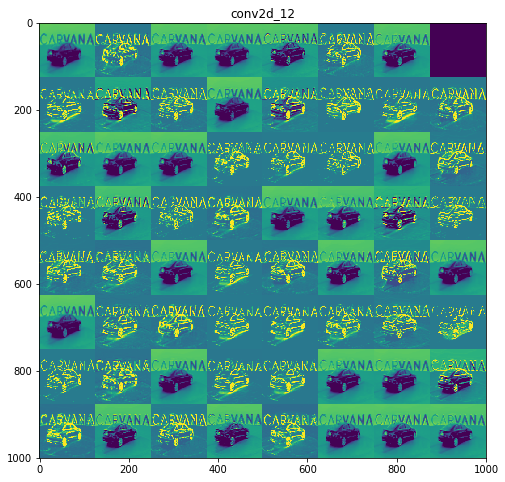

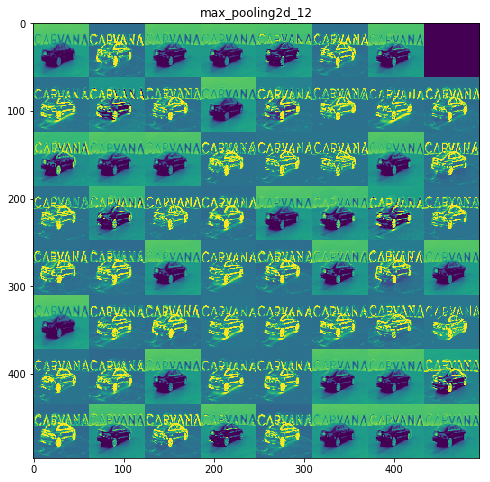

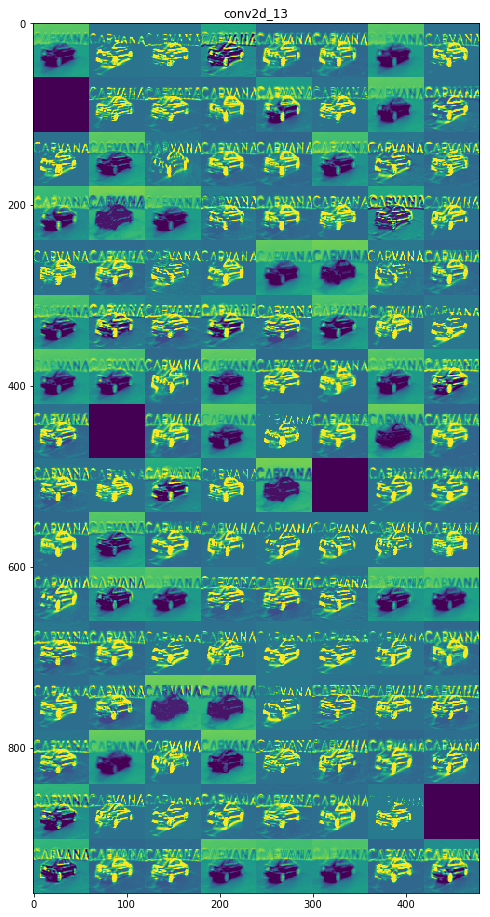

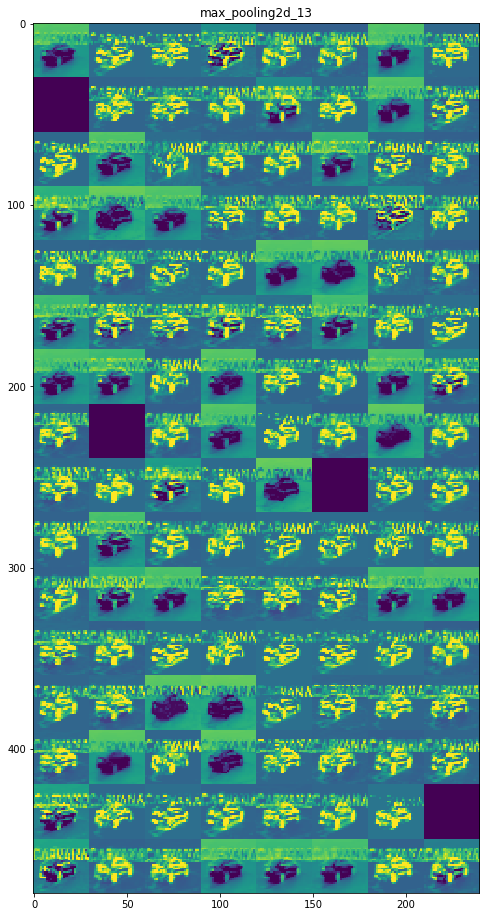

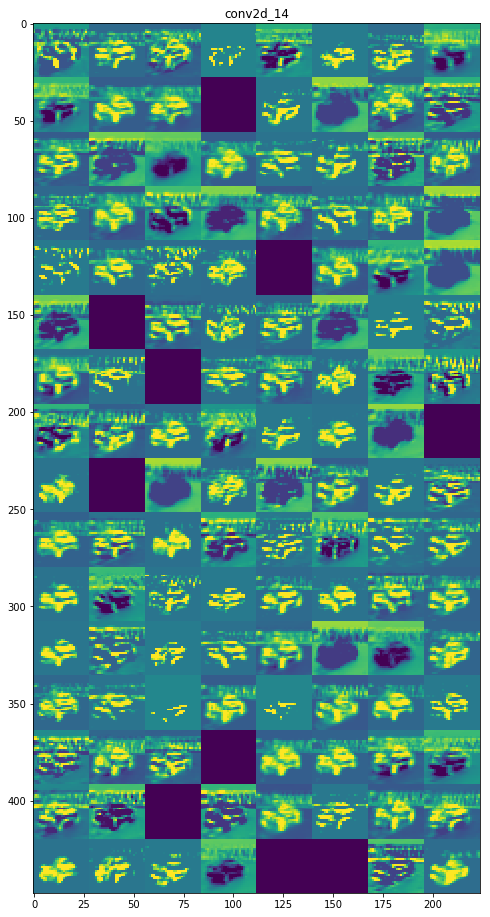

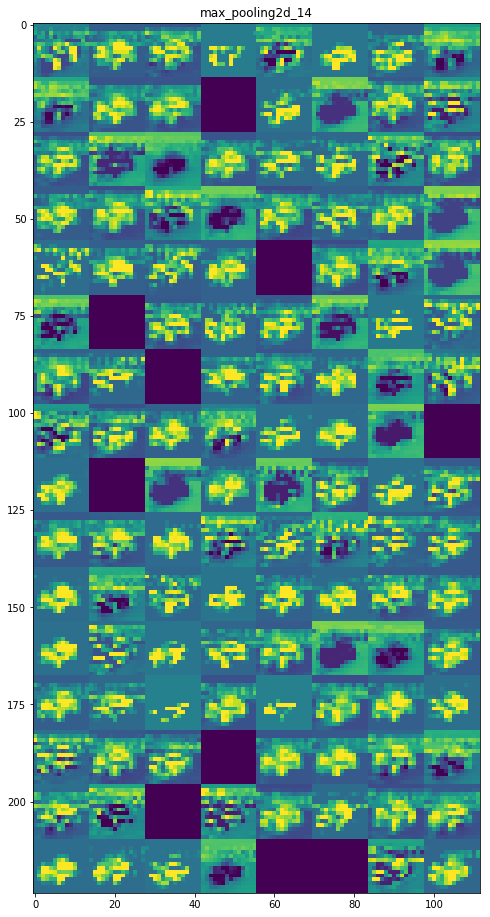

In [11]:
# プロットの一部として使用する層の名前
layer_names = []
for layer in model.layers[:out_num]:
    layer_names.append(layer.name)
    
images_per_row = out_num

# 特徴マップを表示
for layer_name, layer_activation in zip(layer_names, activations):
    # 特徴マップに含まれている特徴量の数
    n_features = layer_activation.shape[-1]
    print("n_features :",n_features,layer_activation.shape)
    
    # 特徴マップの形状(1, size, size, n_features)
    size = layer_activation.shape[1]
    
    # この行列で活性化チャネルのタイルを表示
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    # 各フィルタを１つの大きな水平グリッドでタイル表示
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row + row]
            # 特徴量の見た目を良くするための後処理
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size:((row+1)*size) ] = channel_image
            
    # グリッドを表示
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
                   
plt.show()

### 分かること

* 最初の層は様々なエッジ検出のコレクションの役割を果たす。この段階では、元の画像に存在している情報はほぼ全てが活性化に含まれている。
* 層から層に進むにつれて、活性化は徐々に抽象化されていくので、視覚的な解釈可能性は低下している。つまりAuid-a3らしさや、BMW-x3らしさなどをエンコードするようになる。
* 活性化の疎性は、層が深くなるほど高くなる。つまり、最初の層では全ての画像が入力画像によって活性化されるが、その後の層では空のフィルタが増えていく。フィルタが空であることはそのフィルタにエンコードされているパターンが入力画像から検出されないことを意味している。（0に近ければ近いほど黒っぽい画像になる)

* 背景のCARVANAの文字に対して活性化を示さなくなる -> 層が深くなるにつれてより車という抽象的な概念をとらえるようになっていることを示していると考えられる。

### 2. CNNのフィルタの可視化
* 目的: CNNの各フィルタが受け入れる視覚パターンや視覚概念がどのようなものであるのかを正確に理解するため

VGG16(ImageNet学習済み)を用いる

In [12]:
# フィルタを可視化するための損失テンソルの定義
model = models.load_model('models/VGG16_mini_extended_fine2.h5')
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [13]:
# 入力に関する損失関数の勾配を取得
# gradientsの呼び出しはテンソル（この場合はサイズ１）のリストを返すので、最初の要素のみを保持する
grads = K.gradients(loss, model.input)[0]

### 勾配の正規化
勾配テンソルをそのL2ノルム（テンソルの値の二乗の和の平方根）で割る  
これにより、入力画像に対して実行される更新の大きさが常に同じ範囲に収まる

In [14]:
# 除算の前に1e-5を足すことで0割を回避
grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)

入力画像に基づいて損失テンソルと勾配テンソルの値を計算する方法が必要になる。  
そこで、この計算を行うkerasのバックエンド関数を自作で定義する。  
関数```iterate```は入力としてNumpyテンソル(サイズ１のテンソルのリスト)を受け取り、出力として２つのNumpyテンソル（損失値と勾配値）のリストを返す関数。

In [15]:
# 入力値をnumpy配列で受け取り、出力値をnumpy配列で返す関数の定義
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,input_size,input_size,3))])

### 確率的勾配降下法を用いて損失値を最大化

In [16]:
# 最初はノイズが含まれたグレースケール画像を使用
input_img_data = np.random.random((1, input_size, input_size, 3)) * 20 + 128.

# 勾配上昇法を40ステップ実行
step = 1. #各勾配の更新の大きさ
for i in range(40):
    # 損失値と勾配値を計算
    loss_value, grads_value = iterate([input_img_data])
    # 損失値が最大になる方向に画像を調整
    input_img_data += grads_value * step

結果として得られる画像テンソルは(1, input_size, input_size, 3)のfloat型なので、[0, 255]の範囲の整数に変換する

### テンソルを有効な画像に変換する関数

In [17]:
def deprocess_image(x):
    #テンソルを正規化：中心を0、標準偏差を0.1にする
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # [0, 1]でクリッピング
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # RGB配列に変換
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### フィルタを可視化するための関数

In [18]:
def generate_pattern(layer_name, filter_index, size=256):
    # ターゲット層のn番目のフィルタの活性化を最大化する損失関数を構築
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # この損失関数を使って入力画像の勾配を計算
    grads = K.gradients(loss, model.input)[0]
    
    # 勾配を正規化
    grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)
    
    # 入力画像に基づいて損失値と勾配値を返す関数
    iterate = K.function([model.input], [loss, grads])
    
    # 最初はノイズが含まれたグレースケール画像を用いる
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128.
    
    # 勾配上昇法を40ステップ実行
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value *step
    
    img = input_img_data[0]
    return deprocess_image(img)

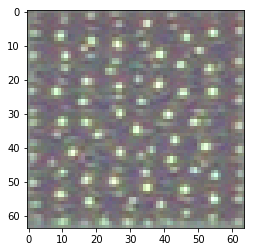

In [19]:
plt.imshow(generate_pattern('block3_conv1', 0, 64))
plt.show()

層block3_conv1の0番チャネルの出力  

水玉模様のパターンに応答していることが分かる

#### 各層の最初から64個のフィルタのみを調べる
また、ここでは、４つのたたみ込みブロックの最初の層(block1_conv1, block2_conv1, block3_conv1,block4_conv1,block5_conv1)を調べる  

出力は64×64のフィルタパターンからなる8×8のグリッドにまとめる。  
各フィルタパターンを黒で縁取りする。

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

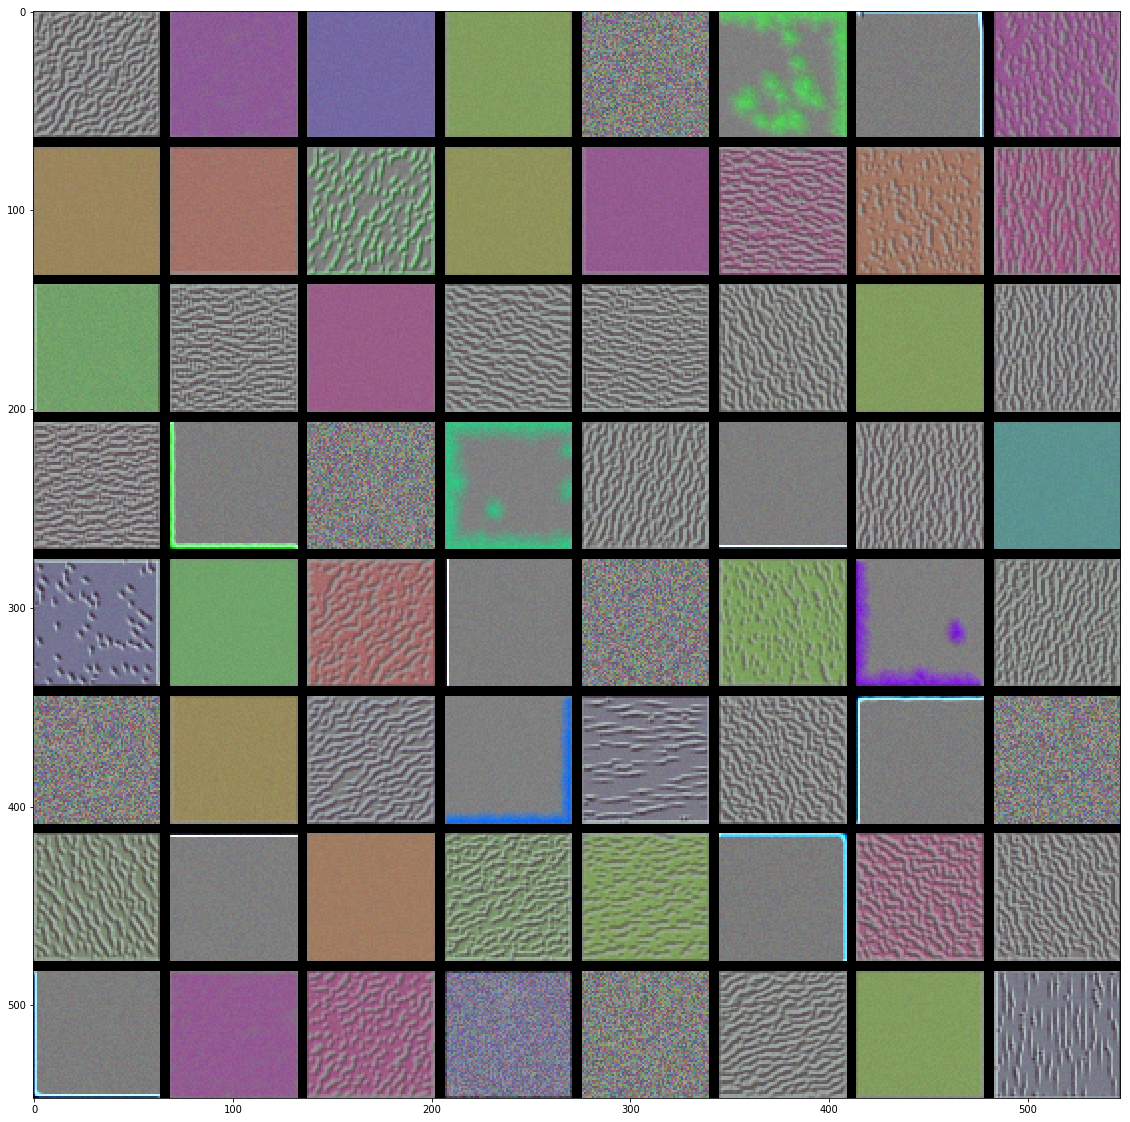

 20%|████████████████▊                                                                   | 1/5 [00:19<01:18, 19.54s/it]

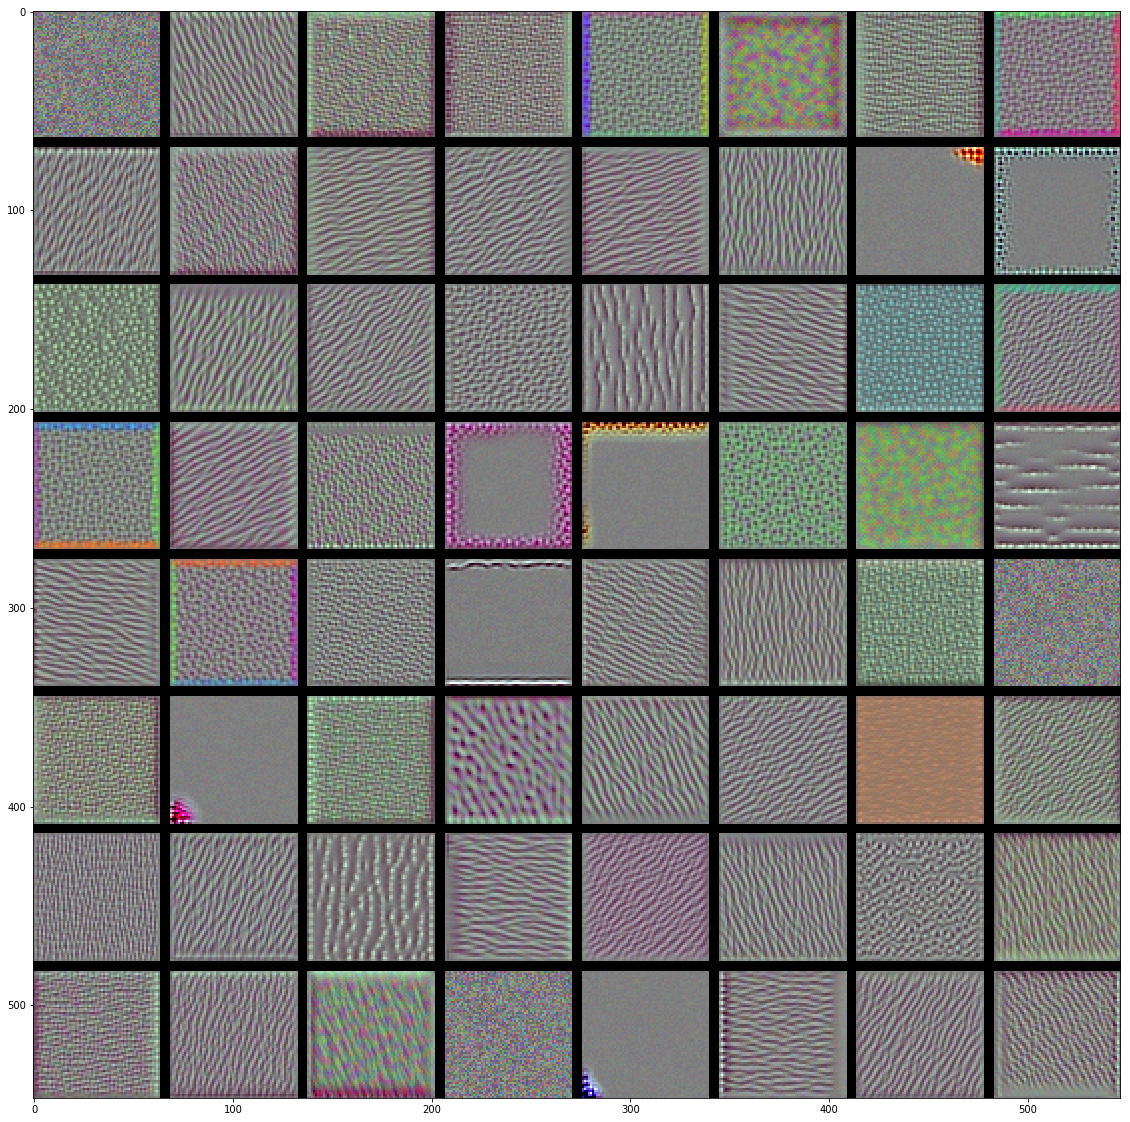

 40%|█████████████████████████████████▌                                                  | 2/5 [01:45<01:58, 39.54s/it]

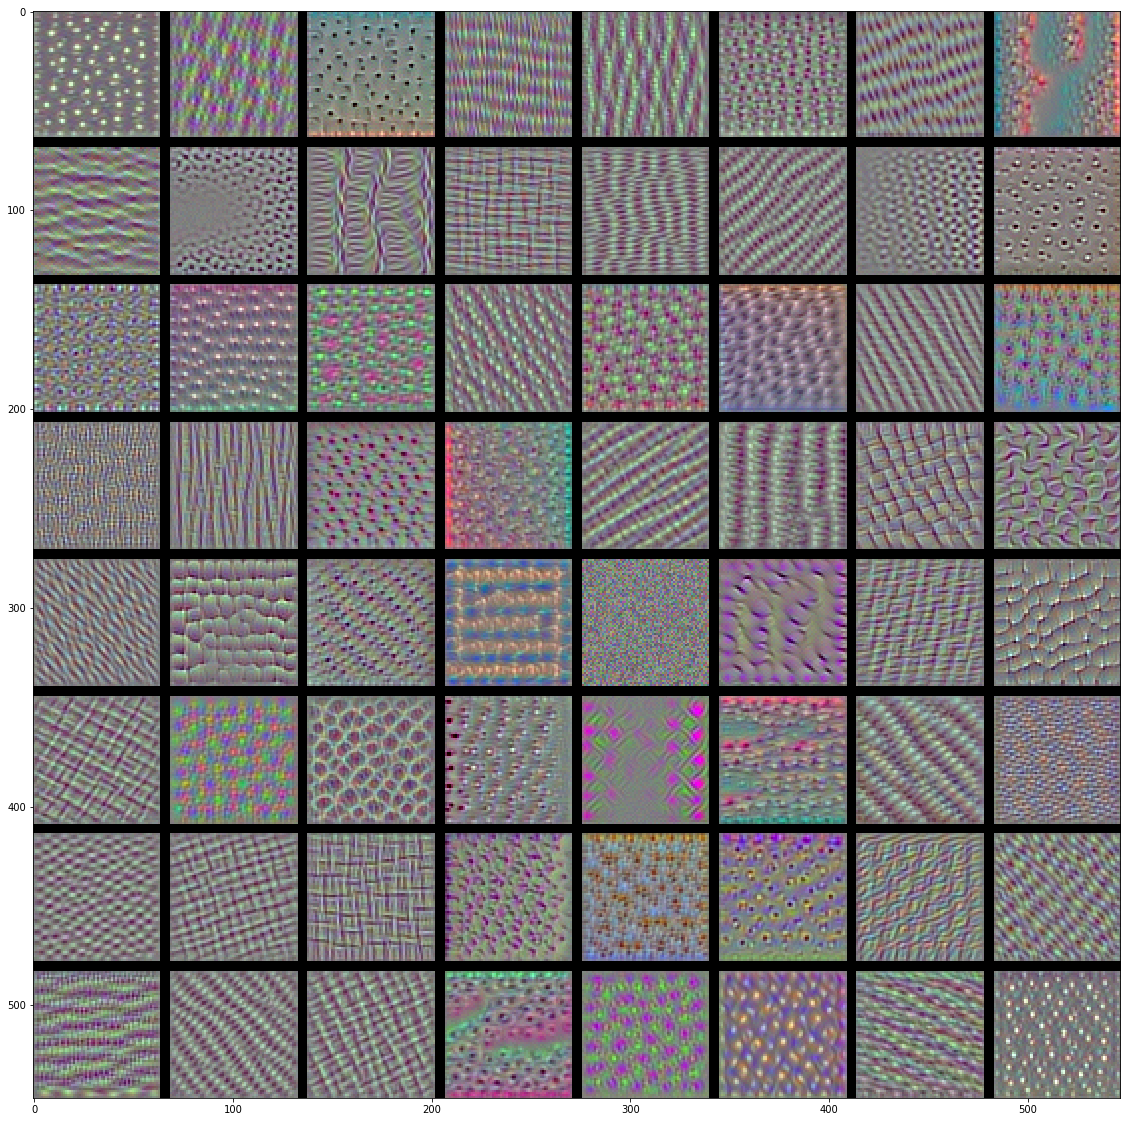

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:29<02:33, 76.93s/it]

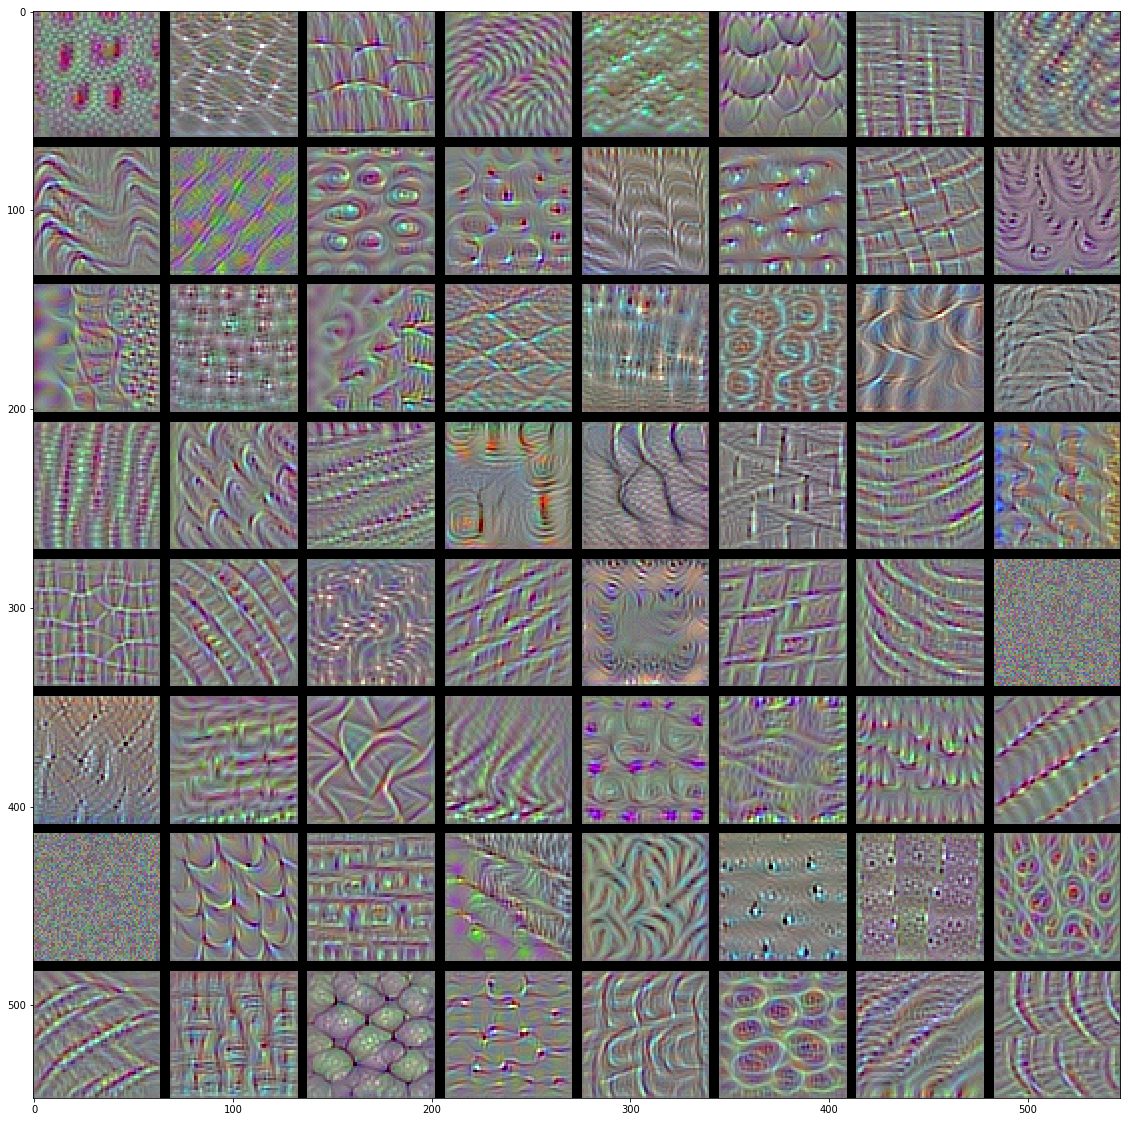

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [09:14<02:19, 139.13s/it]

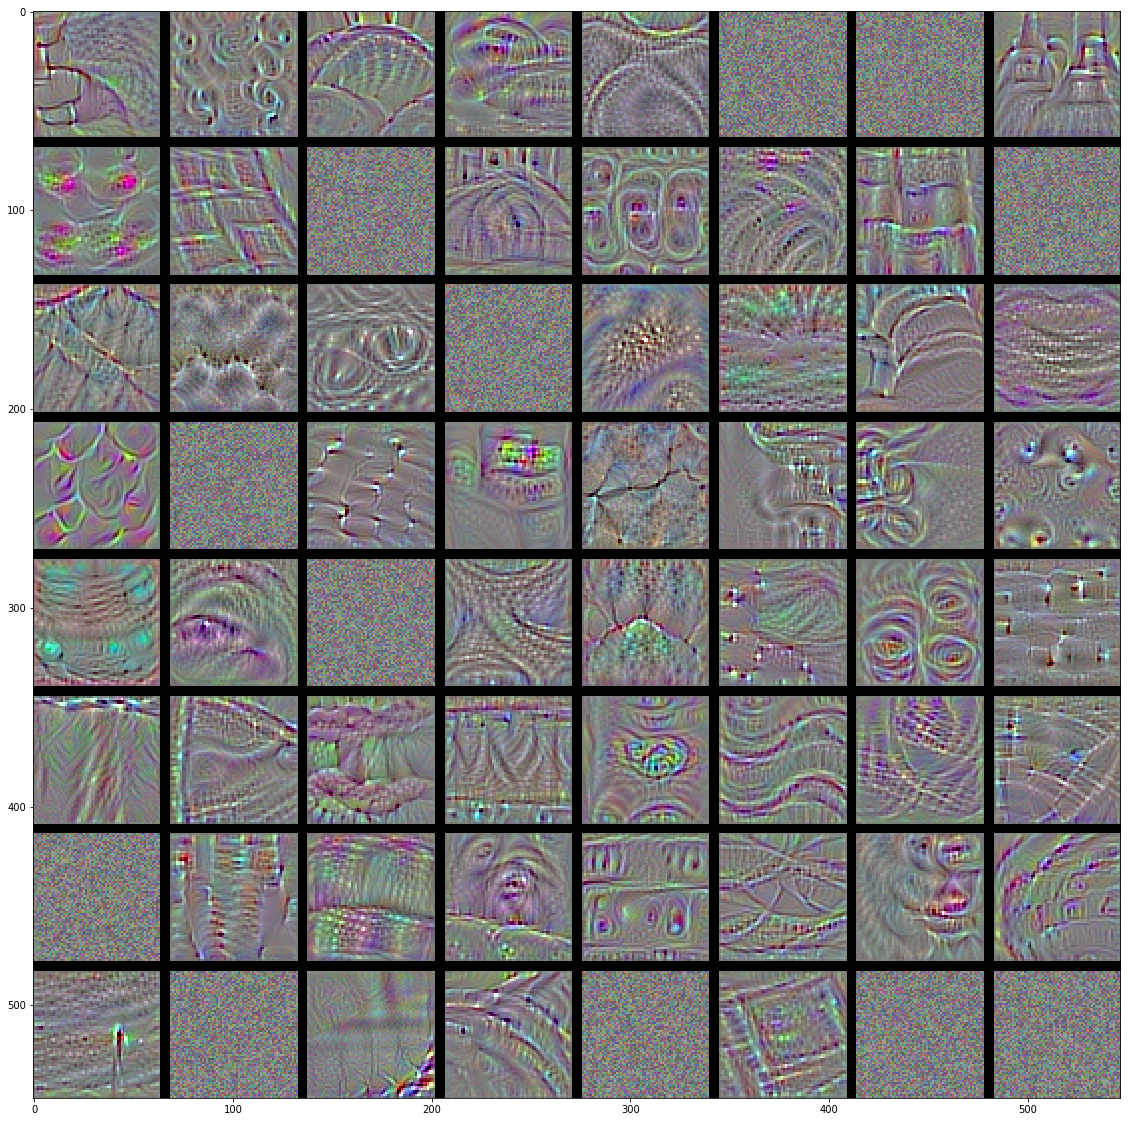

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [30:25<00:00, 478.68s/it]


In [20]:
layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
for layer_name in tqdm(layers):
    size = 64
    margin = 5
    
    # 結果を格納する空(黒)の画像 
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), np.uint8)
    
    for i in range(8): # resultsのグリッドの行を順番に処理
        for j in range(8): # resultsのグリッドの列を順番に処理
            
            # layer_nameのフィルタ i + (j * 8)のパターンを生成
            filter_img = generate_pattern(layer_name, i+(j*8),size=size)
            
            # resultsグリッドの短形(i,j)に結果を表示
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img
            
    # resultsグリッドを表示
    plt.figure(figsize=(20,20))
    plt.imshow(results)
    plt.show()

### フィルタの可視化から分かること

* たたみ込み層が世界をどのようにとらえているのかを理解できる

* CNNの各層は、一連のフィルタを学習することで入力をフィルタの組み合わせとして表現できるようにする。
* そのため、仕組みとしてはフーリエ変換によって信号がcos関数に変換されることと同じことが起こっている。
* 出力側に近ければ近いほど複雑なフィルタになる（高周波成分のようなもの）

### 3. 画像におけるクラス活性化のヒートマップの可視化
* 目的: 画像のどの部分が特定のクラスに属していると見なされたのかを理解するため。これにより、画像内のオブジェクトを局所化できるようになる。

### 学習済みモデルの重みを読み込む

In [21]:
choice = 1
if choice == 1:
    my_model = models.load_model('models/VGG16_mini_extended_fine2.h5') #ファインチューニング
    save_path = "results_pictures/Fine"
    last_layer_name = 'block5_conv3'
elif choice == 2:
    my_model = models.load_model('models/VGG16_mini_3.h5')# 転移学習モデル
    save_path = "results_pictures/Trans"
    last_layer_name = 'block5_conv3'
else:
    my_model = models.load_model('models/4_dense_mini.h5')# 自作モデル
    save_path = "results_pictures/Original"
    last_layer_name = 'conv2d_3'

In [22]:
my_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [23]:
df2 = pd.read_csv('incorrect/df2.csv')
img_path = df2["PATH"][4]
mkname = 'BMW-x3'

In [24]:
# データの前処理
img = image.load_img(img_path, target_size=(256, 256))

# xは形状が(256,256,3)のfloat32型のnumpy配列
x = image.img_to_array(img)/255.0

# この配列サイズが(1, 256, 256, 3)のバッチに変換するために次元を追加
x = np.expand_dims(x, axis=0)

# バッチの前処理（チャネルごとに色を正規化）
# x = preprocess_input(x)
# x = deprocess_image(x)

画像に学習済みネットワークを適応し、予測ベクトルを人が読めるようにする

In [25]:
preds = my_model.predict(x)
print(np.argmax(preds[0]))

6


この画像において最もAudi-a3ぽく見える場所を可視化するためにGrad-CAMプロセスを設定する

(16, 16)


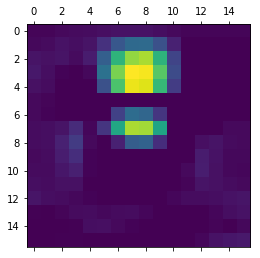

In [26]:
# 予測ベクトルのAudi-a3エントリ
output = my_model.output[:,np.argmax(preds[0])]
# simplest_cnn_model_mini_1の最後の層であるconv2d_15の出力特徴マップ
last_conv_layer = my_model.get_layer(last_layer_name)
# conv2d_15の出力特徴マップでの「Audi-a3」クラス勾配
grads = K.gradients(output,last_conv_layer.output)[0]

# 形状が(32, )のベクトル
# 各エントリは特定の特徴マップの平均強度
pooled_grads = K.mean(grads,axis=(0,1,2))
#Audi-a3の画像に基づいてpooled_gradsとconv2d_15の出力マップの値にアクセスするための関数
iterate = K.function([my_model.input], [pooled_grads, last_conv_layer.output[0]])

# 2つの値をNumpy配列で取得
pooled_grads_value, conv_layer_output_value = iterate([x])

# 「Audi-a3」クラスに関する「このチャネルの重要度」を特徴マップ配列の各チャネルに掛ける
for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

# 最終的な特徴マップのチャネルごとの平均値がクラスの活性化のヒートマップ
heatmap = np.mean(conv_layer_output_value,axis=-1 )

# ヒートマップの後処理
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### openCVを用いてヒートマップを元の画像にスーパーインポーズ

In [27]:
# cv2を使って画像読み込み
img = cv2.imread(img_path)
# 元画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)
# ヒートマップをもとの画像に適応
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4はヒートマップの強度係数
superimporsed_img = heatmap * 0.4 + img
# 画像を保存
cv2.imwrite(save_path+mkname+'1.jpg',superimporsed_img)

True

### Grad-Camのmainの処理
* 入力画像の読み込み
* モデルの読み込み
* 入力画像の予測確率(predictions)と予測ｸﾗｽ(predicted_class)の計算
* Grad-Camの計算
* 画像の保存

<function matplotlib.pyplot.show(*args, **kw)>

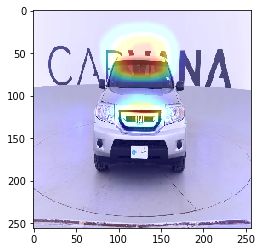

In [32]:
img = image.load_img(save_path+mkname+'1.jpg', target_size=(input_size,input_size))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show